In [455]:
# !pip install mplsoccer
# !pip install statsbombpy

In [456]:
from mplsoccer.pitch import Pitch
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from statsbombpy import sb
import pandas as pd
import numpy as np
import warnings
import ast
from pandas.errors import SettingWithCopyWarning
from statsbombpy.api_client import NoAuthWarning

warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=NoAuthWarning)

<br><br><br><br>
### Jupyter - loading_bar_html

In [457]:
from IPython.display import display, HTML
loading_bar_html = """
<div id="progress-container" style="width: 50%; border: 1px solid #ccc; margin: 20px 0;">
  <div id="progress-bar" style="width: 0%; height: 20px; background-color: #4CAF50; text-align: center; line-height: 20px; color: white;"></div>
</div>
<script>
function updateProgressBar(progress) {
  var progressBar = document.getElementById('progress-bar');
  progressBar.style.width = progress + '%';
  progressBar.innerHTML = progress + '%';
}
</script>
"""

<br><br><br><br>
# ast.literal_eval(master_events_df)

In [458]:
# competition_id = 9
# season_id = 281
# all_events = []
# matches = sb.matches(competition_id=competition_id, season_id=season_id)
# matches_ids = matches["match_id"] #[3895074] #matches["match_id"]
# match_number = len(matches_ids)

# display(HTML(loading_bar_html)) # loading_bar_html
# for process, match_id in enumerate(matches_ids):
#     events = sb.events(match_id=match_id)
#     all_events.append(events) 
#     progress = int((process + 1) / match_number * 100) # loading_bar_html
#     display(HTML("<script>updateProgressBar({})</script>".format(progress))) # loading_bar_html
# print("__completed__!")
# master_events_df = pd.concat(all_events, ignore_index=True)

In [459]:
master_events_df = pd.read_csv("data/Bayer Leverkusen Bundesliga 23-24 Statsbomb Events Data.csv", low_memory=False)

In [461]:
master_events_df['location'] = master_events_df['location'].fillna('[]')
master_events_df['location'] = master_events_df['location'].apply(ast.literal_eval)
master_events_df['y'] = master_events_df['location'].apply(lambda loc: loc[0] if loc else None)
master_events_df['x'] = master_events_df['location'].apply(lambda loc: loc[1] if loc else None)


master_events_df['pass_end_location'] = master_events_df['pass_end_location'].fillna('[]')
master_events_df['pass_end_location'] = master_events_df['pass_end_location'].apply(ast.literal_eval)
master_events_df['pass_end_y'] = master_events_df['pass_end_location'].apply(lambda loc: loc[0] if loc else None)
master_events_df['pass_end_x'] = master_events_df['pass_end_location'].apply(lambda loc: loc[1] if loc else None)

<img src="https://i.ibb.co/54hgbWX/image.png">
<!-- events_df[events_df['type'] == "Shot"][["player","location","shot_statsbomb_xg","timestamp"]] -->

In [462]:
master_events_df.type.unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt*', 'Carry',
       'Pressure', 'Miscontrol', 'Dribble', 'Duel', 'Interception',
       'Ball Recovery', 'Dispossessed', 'Block', 'Foul Committed',
       'Foul Won', 'Error', 'Shot', 'Goal Keeper', 'Injury Stoppage',
       'Referee Ball-Drop', '50/50', 'Clearance', 'Offside',
       'Dribbled Past', 'Player Off', 'Player On', 'Half End',
       'Substitution', 'Bad Behaviour', 'Tactical Shift', 'Shield',
       'Own Goal For', 'Own Goal Against'], dtype=object)

In [463]:
file_title = "yyleverkusen_2024" + "_"
pitch_color = "pink"
#ATTRIBUTES_LIST = ["Pass","Shot","Dribble"]
ATTRIBUTES_LIST = ["Shot"]

Shot is completed!


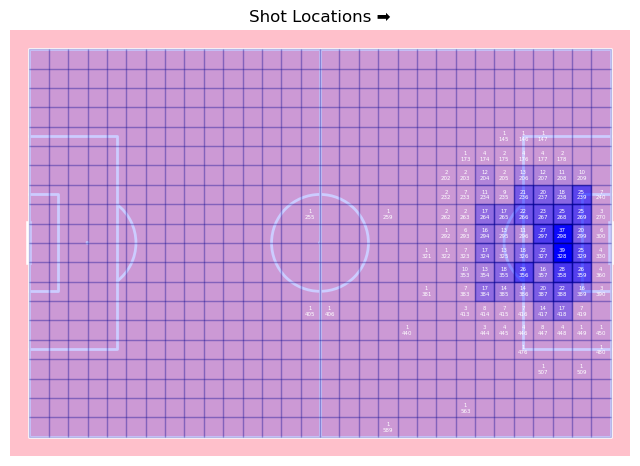

In [464]:
for ATTRIBUTE_TITLE in ATTRIBUTES_LIST:
    actions_df = master_events_df[(master_events_df['type'] == ATTRIBUTE_TITLE) & (master_events_df['position'] != "xRight Back")].copy()  
    
    pitch_yard_y = 120
    pitch_yard_x = 80
    yard_y_squares = 30
    yard_x_squares = 20
    
    y_intervals = [(i*pitch_yard_y/yard_y_squares, (i+1)*pitch_yard_y/yard_y_squares) for i in range(yard_y_squares)]  # Y-axis intervals
    x_intervals = [(i*pitch_yard_x/yard_x_squares, (i+1)*pitch_yard_x/yard_x_squares) for i in range(yard_x_squares)]  # X-axis intervals

    counts_list = []
    for x_interval in x_intervals:
        for y_interval in y_intervals:
            count = actions_df[
                (actions_df['x'] >= x_interval[0]) & (actions_df['x'] <= x_interval[1]) &
                (actions_df['y'] >= y_interval[0]) & (actions_df['y'] <= y_interval[1])
            ].shape[0]
            counts_list.append({
                'x_interval': x_interval,
                'y_interval': y_interval,
                'count': count
            })
    counts_df = pd.DataFrame(counts_list)
    counts_df['percentage'] = round(counts_df['count'] / counts_df['count'].sum() * 100, 2)
    counts_df['Pitch_Number'] = range(1, len(counts_df) + 1)

    def MinMaxNormalization(X):
        min_X = X.min()
        max_X = X.max()
        return (X-min_X) / (max_X-min_X)
    counts_df["alpha"] = MinMaxNormalization(counts_df["count"])
    counts_df['count'].fillna(0, inplace=True)
    #counts_df.to_csv(f"{file_title}{ATTRIBUTE_TITLE}_locations.csv", index=False)
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color=pitch_color, line_color='white')
    fig, ax = plt.subplots(figsize=(8, 12))
    pitch.draw(ax=ax)
    def draw_intervals(df, ax):
        for _, row in df.iterrows():
            x_start, x_end = row['x_interval']
            y_start, y_end = row['y_interval']
            count = row['count']
            percentage = row['percentage']
            pitch_number = row['Pitch_Number']
            alphaValue = row['alpha']
            
            # Create a rectangle patch
            rect = patches.Rectangle(
                (y_start, x_start), 
                y_end - y_start,
                x_end - x_start, 
                linewidth=1,
                edgecolor='darkblue',
                facecolor='blue',
                alpha=max(0.2, alphaValue)
            )
            
            # Add rectangle to the plot
            ax.add_patch(rect)
            
            # Add text to the rectangles
            if count:
                ax.text(
                    (y_start + y_end) / 2,
                    (x_start + x_end) / 2, 
                    f'{count}\n{pitch_number}', #f'{percentage}% \n {count} \n {pitch_number}',
                    ha='center', va='center',
                    fontsize=3.9, color='white'
                )
    
    draw_intervals(counts_df, ax)
    plt.title(f'{ATTRIBUTE_TITLE} Locations ➡️')
    #saved_fig = fig.savefig(f"IMG/{file_title}{ATTRIBUTE_TITLE}_Locations.png", dpi=300, bbox_inches='tight')
    TESTsaved_fig = fig.savefig(f"IMG/statsbomb.png", dpi=300, bbox_inches='tight')
    print(f'{ATTRIBUTE_TITLE} is completed!')

In [465]:
counts_df.sort_values(by="percentage", ascending=False)

,x_interval,y_interval,count,percentage,Pitch_Number,alpha
327,"(40.0, 44.0)","(108.0, 112.0)",39,3.99,328,1.000000
297,"(36.0, 40.0)","(108.0, 112.0)",37,3.78,298,0.948718
357,"(44.0, 48.0)","(108.0, 112.0)",28,2.86,358,0.717949
296,"(36.0, 40.0)","(104.0, 108.0)",27,2.76,297,0.692308
358,"(44.0, 48.0)","(112.0, 116.0)",26,2.66,359,0.666667
...,...,...,...,...,...,...
185,"(24.0, 28.0)","(20.0, 24.0)",0,0.00,186,0.000000
184,"(24.0, 28.0)","(16.0, 20.0)",0,0.00,185,0.000000
183,"(24.0, 28.0)","(12.0, 16.0)",0,0.00,184,0.000000
182,"(24.0, 28.0)","(8.0, 12.0)",0,0.00,183,0.000000


In [466]:
tactics = pd.read_excel("tactical_index_fm23.xlsx")

In [467]:
fils = tactics.Philosophy.dropna().unique()

In [468]:
styles = tactics.Style.dropna().unique()

In [469]:
combs = []
for f in fils:
    for s in styles:
        combs.append(f"{f} - {s}")

<br><br><br><br><br><br><br><br>
# Pass - Receive Locations

In [470]:
file_title = "yyleverkusen_2024" + "_"
pitch_color = "pink"
#ATTRIBUTES_LIST = ["Pass","Shot","Dribble"]
ATTRIBUTES_LIST = ["Shot"]

In [472]:
def PitchLocater(row, row_x, row_y, xy_map, x_intervals, y_intervals):
    x = row[row_x]
    y = row[row_y]
    for x_interval in x_intervals:
        if x_interval[0] <= x <= x_interval[1]:
            for y_interval in y_intervals:
                if y_interval[0] <= y <= y_interval[1]:
                    return xy_map[(x_interval, y_interval)]
    return None

In [471]:
pitch_yard_y = 120
pitch_yard_x = 80
yard_y_squares = 24
yard_x_squares = 16
y_intervals = [(i*pitch_yard_y/yard_y_squares, (i+1)*pitch_yard_y/yard_y_squares) for i in range(yard_y_squares)]
x_intervals = [(i*pitch_yard_x/yard_x_squares, (i+1)*pitch_yard_x/yard_x_squares) for i in range(yard_x_squares)]
xy_intervals = [(x,y) for x in x_intervals for y in y_intervals]
xy_map = {xy_intervals[i]: i+1 for i in range(0, len(xy_intervals))}
pitch_map = {i+1: xy_intervals[i] for i in range(0, len(xy_intervals))}

master_events_df["Pitch_Number"] = master_events_df.apply(lambda row: PitchLocater(row, "x", "y",xy_map, x_intervals, y_intervals), axis=1)
master_events_df["pass_end_Pitch_Number"] = master_events_df.apply(lambda row: PitchLocater(row, "pass_end_x", "pass_end_y", xy_map, x_intervals, y_intervals), axis=1)
master_events_df["Pass_Stream"] = master_events_df.apply(lambda row: [row["Pitch_Number"], row["pass_end_Pitch_Number"]], axis=1)

Shot is completed!


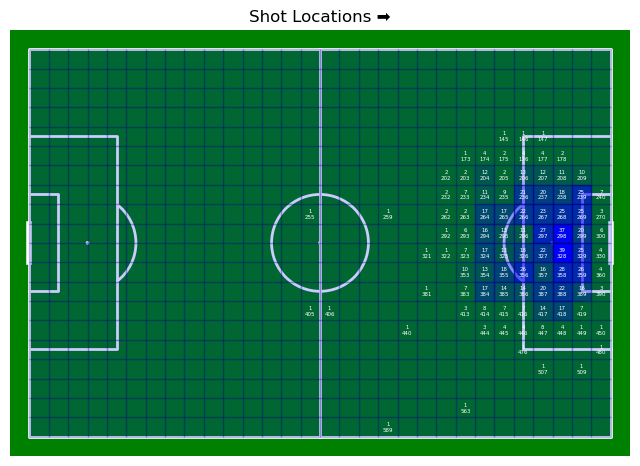

In [474]:
for ATTRIBUTE_TITLE in ATTRIBUTES_LIST:
    actions_df = master_events_df[(master_events_df['type'] == ATTRIBUTE_TITLE) & (master_events_df['position'] != "xRight Back")].copy()  
    
    pitch_yard_y = 120
    pitch_yard_x = 80
    yard_y_squares = 30
    yard_x_squares = 20
    y_intervals = [(i*pitch_yard_y/yard_y_squares, (i+1)*pitch_yard_y/yard_y_squares) for i in range(yard_y_squares)]  # Y-axis intervals
    x_intervals = [(i*pitch_yard_x/yard_x_squares, (i+1)*pitch_yard_x/yard_x_squares) for i in range(yard_x_squares)]  # X-axis intervals

    counts_list = []
    for x_interval in x_intervals:
        for y_interval in y_intervals:
            count = actions_df[
                (actions_df['x'] >= x_interval[0]) & (actions_df['x'] <= x_interval[1]) &
                (actions_df['y'] >= y_interval[0]) & (actions_df['y'] <= y_interval[1])
            ].shape[0]
            counts_list.append({
                'x_interval': x_interval,
                'y_interval': y_interval,
                'count': count
            })
    counts_df = pd.DataFrame(counts_list)
    counts_df['percentage'] = round(counts_df['count'] / counts_df['count'].sum() * 100, 2)
    counts_df['Pitch_Number'] = range(1, len(counts_df) + 1)

    def MinMaxNormalization(X):
        min_X = X.min()
        max_X = X.max()
        return (X-min_X) / (max_X-min_X)
    counts_df["alpha"] = MinMaxNormalization(counts_df["count"])
    counts_df['count'].fillna(0, inplace=True)
    #counts_df.to_csv(f"{file_title}{ATTRIBUTE_TITLE}_locations.csv", index=False)
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color="green", line_color='white')
    fig, ax = plt.subplots(figsize=(8, 12))
    pitch.draw(ax=ax)
    def draw_intervals(df, ax):
        for _, row in df.iterrows():
            x_start, x_end = row['x_interval']
            y_start, y_end = row['y_interval']
            count = row['count']
            percentage = row['percentage']
            pitch_number = row['Pitch_Number']
            alphaValue = row['alpha']
            
            # Create a rectangle patch
            rect = patches.Rectangle(
                (y_start, x_start), 
                y_end - y_start,
                x_end - x_start, 
                linewidth=1,
                edgecolor='darkblue',
                facecolor='blue',
                alpha=max(0.2, alphaValue)
            )
            
            # Add rectangle to the plot
            ax.add_patch(rect)
            
            # Add text to the rectangles
            if count:
                ax.text(
                    (y_start + y_end) / 2,
                    (x_start + x_end) / 2, 
                    f'{count}\n{pitch_number}', #f'{percentage}% \n {count} \n {pitch_number}',
                    ha='center', va='center',
                    fontsize=3.9, color='white'
                )
    
    draw_intervals(counts_df, ax)
    plt.title(f'{ATTRIBUTE_TITLE} Locations ➡️')
    #saved_fig = fig.savefig(f"IMG/{file_title}{ATTRIBUTE_TITLE}_Locations.png", dpi=300, bbox_inches='tight')
    TESTsaved_fig = fig.savefig(f"IMG/statsbomb.png", dpi=300, bbox_inches='tight')
    print(f'{ATTRIBUTE_TITLE} is completed!')

<br><br><br><br><br><br><br><br>
# Bayern Münich v. Bayer Leverkusen - Events

In [475]:
all_events = []
matches_ids = [3895074]

for process, match_id in enumerate(matches_ids):
    events = master_events_df[(master_events_df.match_id == match_id) & (master_events_df.period == 2)]
    all_events.append(events) 
    
events_df = pd.concat(all_events, ignore_index=True)

In [476]:
events_df[(events_df['type'] == "Pass")].pass_outcome.fillna("Successful", inplace=True)
events_df[(events_df['type'] == "Pass")].pass_outcome.value_counts(dropna=False)

NaN             530
Incomplete       74
Pass Offside      2
Unknown           2
Out               1
Name: pass_outcome, dtype: int64

In [477]:
outcome_columns_df = events_df[events_df.columns[events_df.columns.str.contains("_outcome")]].columns
type_columns_df = events_df[events_df.columns[events_df.columns.str.contains("_type")]].columns
type_columns_df

Index(['duel_type', 'goalkeeper_type', 'pass_type', 'shot_type',
       'foul_committed_type'],
      dtype='object')

<br><br><br><br><br><br><br><br>
# Pitch Number Counter

In [478]:
pitch_yard_y = 120
pitch_yard_x = 80
yard_y_squares = 24
yard_x_squares = 16
y_intervals = [(i*pitch_yard_y/yard_y_squares, (i+1)*pitch_yard_y/yard_y_squares) for i in range(yard_y_squares)]
x_intervals = [(i*pitch_yard_x/yard_x_squares, (i+1)*pitch_yard_x/yard_x_squares) for i in range(yard_x_squares)]
xy_intervals = [(x,y) for x in x_intervals for y in y_intervals]
xy_map = {xy_intervals[i]: i+1 for i in range(0, len(xy_intervals))}
pitch_map = {i+1: xy_intervals[i] for i in range(0, len(xy_intervals))}

In [479]:
df = master_events_df.copy()

def Generate_counts_df(df, action):
    df2 = pd.DataFrame()
    action_locations = df.query(f"type == '{action}'").Pitch_Number.value_counts().sort_index().to_dict()
    df2["Pitch_Number"] = list(range(1, yard_y_squares*yard_x_squares+1))
    action_dict = pd.Series(action_locations).sort_index()
    df2['count'] = counts_df['Pitch_Number'].map(action_dict)
    df2["count"].fillna(0, inplace=True)
    df2["x_interval"] = df2["Pitch_Number"].apply(lambda i: pitch_map[i][0])
    df2["y_interval"] = df2["Pitch_Number"].apply(lambda i: pitch_map[i][1])
    df2["percentage"] = df2["count"]/df2["count"].sum()
    return df2

In [480]:
Generate_counts_df(df, "Pass")

,Pitch_Number,count,x_interval,y_interval,percentage
0,1,14.0,"(0.0, 5.0)","(0.0, 5.0)",0.000357
1,2,40.0,"(0.0, 5.0)","(5.0, 10.0)",0.001020
2,3,51.0,"(0.0, 5.0)","(10.0, 15.0)",0.001301
3,4,55.0,"(0.0, 5.0)","(15.0, 20.0)",0.001403
4,5,68.0,"(0.0, 5.0)","(20.0, 25.0)",0.001734
...,...,...,...,...,...
379,380,95.0,"(75.0, 80.0)","(95.0, 100.0)",0.002423
380,381,71.0,"(75.0, 80.0)","(100.0, 105.0)",0.001811
381,382,61.0,"(75.0, 80.0)","(105.0, 110.0)",0.001556
382,383,62.0,"(75.0, 80.0)","(110.0, 115.0)",0.001581


In [483]:
file_title = "600sq_leverkusen" + "_"
pitch_color = "beige"
ATTRIBUTES_LIST = ["Pass","Shot","Dribble"]
#ATTRIBUTES_LIST = ["Shot"]

Pass is completed!
Shot is completed!
Dribble is completed!


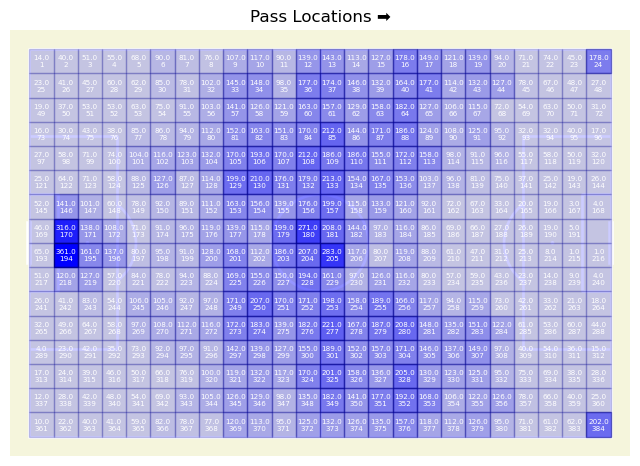

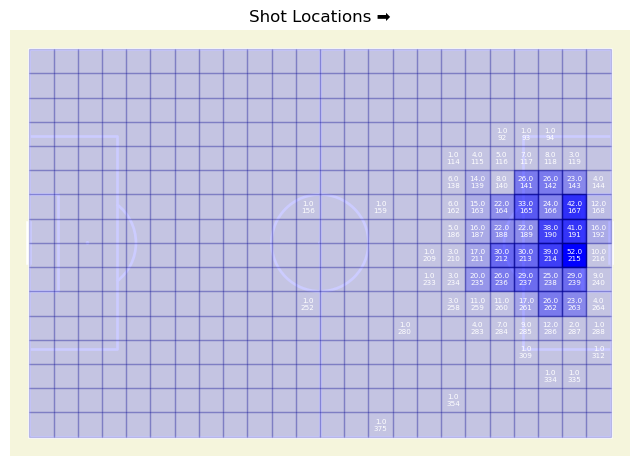

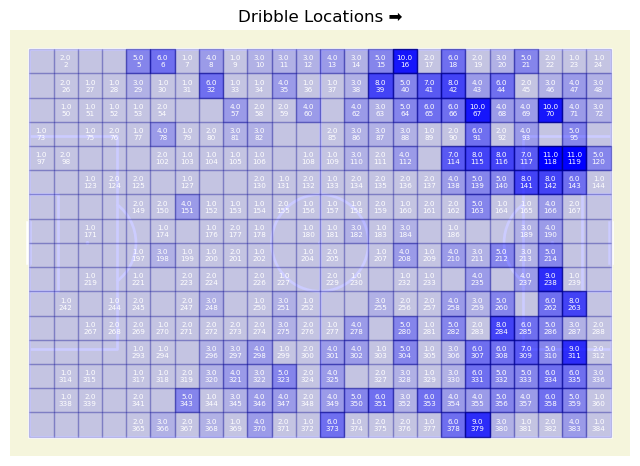

In [486]:
for ATTRIBUTE_TITLE in ATTRIBUTES_LIST:
    counts_df = Generate_counts_df(df, ATTRIBUTE_TITLE)

    def MinMaxNormalization(X):
        min_X = X.min()
        max_X = X.max()
        return (X-min_X) / (max_X-min_X)
    counts_df["alpha"] = MinMaxNormalization(counts_df["count"])
    counts_df.to_csv(f"{file_title}{ATTRIBUTE_TITLE}_locations.csv", index=False)
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color=pitch_color, line_color='white')
    fig, ax = plt.subplots(figsize=(8, 12))
    pitch.draw(ax=ax)
    def draw_intervals(df, ax):
        for _, row in df.iterrows():
            x_start, x_end = row['x_interval']
            y_start, y_end = row['y_interval']
            count = row['count']
            percentage = row['percentage']
            pitch_number = row['Pitch_Number']
            alphaValue = row['alpha']
            
            rect = patches.Rectangle(
                (y_start, x_start), 
                y_end - y_start,
                x_end - x_start, 
                linewidth=1,
                edgecolor='darkblue',
                facecolor='blue',
                alpha=max(0.2, alphaValue)
            )
            
            ax.add_patch(rect)
            if count:
                ax.text(
                    (y_start + y_end) / 2,
                    (x_start + x_end) / 2, 
                    f'{count}\n{pitch_number}', #f'{percentage}% \n {count} \n {pitch_number}',
                    ha='center', va='center',
                    fontsize=5.2, color='white'
                )
    
    draw_intervals(counts_df, ax)
    plt.title(f'{ATTRIBUTE_TITLE} Locations ➡️')
    saved_fig = fig.savefig(f"IMG/{file_title}{ATTRIBUTE_TITLE}_Locations.png", dpi=300, bbox_inches='tight')
    TESTsaved_fig = fig.savefig(f"IMG/statsbomb.png", dpi=300, bbox_inches='tight')
    print(f'{ATTRIBUTE_TITLE} is completed!')